# This program is to cut out GCs with <20 control stars within halfway between rhm and rt
# This is the first test to see if more quality control sets yields better results
# Now we implement Steff's idea about the nearest number of neighbour cutoff to lower the amount of errant control stars we pick up

## Notes for this program

My parameter list is different from Steffani's. My param list is shown below:\\\\
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR', 'SNR', 'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR', 'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR', 'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR', 'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR', 'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']\\\\

So basically the RA index is 4, DEC index is 5, RV index is 10, and the first chemical abundance is at 13. The chemical abundances follow Steffani's form (e.g. abundance1, abundance1_error, abundance2, abundance2_error, etc.). What I did was make the standardizing step for both tSNE and UMAP take in the index of the first chemical abundance and from there it automatically adds 2 for each chem abundance going up.\\\\

Basically if you use my param_list it'll work. The param_list variable is just a list of strings of the index titles, I have a function somewhere that grabs the data for those indices.\\\\

For each GC, we just need the ra, dec, rhm_deg (rhm depends on dist I think).\\
There are global parameters for all GCs as well, so the parameter list, fov, and chemical abundance starting index.\\\\

LMK if shit dont work and there's probably something I forgot to explain.

#### STEP 0: Import the necessary packages/algorithms.

In [1]:
# General analysis/plotting packages:
import matplotlib.pyplot as plt
import numpy as np
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib import rc
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from collections import Counter

# Specific t-SNE/visualization packages:
from sklearn.manifold import TSNE
from shapely.geometry import Point, Polygon

# UMAP shit
# Import UMAP
import umap.umap_ as umap

# Try using SKLEARN's StandardScaler to standardize the data
from sklearn.preprocessing import StandardScaler

# I/O
import sys

# OS
import os

# dbscan
from sklearn.cluster import DBSCAN

# tqdm
from tqdm.notebook import tqdm

# KDTree
from scipy.spatial import cKDTree

# mode
from scipy import stats as st

# music
import simpleaudio as sa

# time
import time

### Step 1: Load in the clusters

#### Load in selected star cluster
Input RA and DEC and the program will load in all the stars within a $10^o$ by $10^o$ FOV.

In [2]:
'''Read in APOGEE CSV file'''

apogee_filt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_filter.csv', delimiter=',')
apogee_nofilt = pd.read_csv('data/APOGEEDR17_GAIAEDR3_noflagfilter.csv', delimiter=',')
GC_db = pd.read_csv('data/GCs_20RHMRT.csv', delimiter=',')

In [3]:
### Finding stars within a set FOV of the GC centre
def find_cluster_stars(ra, dec, fov, df, name, rhm_deg, rt_deg):
    
    stars = []
    for count, i in enumerate(df['RA'].values):
        if i >= ra - fov and i <= ra + fov and df['DEC'].values[count] >= dec - fov and df['DEC'].values[count] <= dec + fov:
            stars.append(df.loc[count])
            
    print(len(stars), 'stars in a 10x10 fov of the GC')
    
    '''if len(stars) != 0:
        # create a folder with name of GC only if there are stars in the field
        try: 
            os.makedirs('GCs_10RHM/' + name)
        except OSError as error:
            print('Directory ' + name+ ' already exists')

    ra_arr = np.empty(len(stars), dtype=float)
    dec_arr = np.empty(len(stars), dtype=float)
    for count, i in enumerate(stars):
        ra_arr[count] = i['RA']
        dec_arr[count] = i['DEC']
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm')
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_arr, dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre')
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title(name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    try:
        plt.savefig('GCs_10RHM/'+name+'/radec.png')
    except:
        print('No stars yo')
    plt.close('all')'''
    
    return stars
            

#### Separating list of stars into lists by parameter

In [4]:
def split_star_list(stars, parameters):
    param_dict = {}
    for i in parameters:
        if str(i) == '# APOGEE_ID_':
            param_dict[str(i)] = np.empty(len(stars), dtype=object)
        else:
            param_dict[str(i)] = np.empty(len(stars))
    for count,i in enumerate(stars):
        for j in parameters:
            param_dict[str(j)][count] = i[str(j)]
            
    return param_dict
        

#### Separating the dictionary values into a columns list

In [5]:
def split_cols(GC_param, parameters):
    cols = []
    for i in range(len(GC_param)):
        cols.append(GC_param[str(parameters[i])])
    
    return cols

#### Master GC load function

In [6]:
def master_load(ra, dec, fov, dataset, params, name, rhm_deg, rt_deg):
    stars_found = find_cluster_stars(ra, dec, fov, dataset, name, rhm_deg, rt_deg)
    GC_dict = split_star_list(stars_found, params)
    GC_cols = split_cols(GC_dict, param_list)
    
    return [GC_dict, GC_cols]
    

### Step 2: Filter the data

#### Filter 1 for data: Removing all stars without PM

In [7]:
def pm_filter(GC_dict, GC_cols):
    ### Filter 1: Remove stars that do not have proper motion values. ###
    pm_filter_nan = np.isnan(GC_dict['GAIAEDR3_PMRA'])
    pm_filter = np.where(pm_filter_nan==False)
    data_pmfilter = []
    for i in GC_cols:
        x = np.array(i)[pm_filter]
        data_pmfilter.append(x)
    #print("There are {} stars in our sample after the proper motion filtering.".format(len(data_pmfilter[0])))
    
    return data_pmfilter

#### Filter 2 for data: Removing all stars that do not have chemical abundances

In [8]:
def chem_filter(data_pmfilter, init_abundance_index):
    ### Filter 2: Remove stars that do not have data for all 19 abundances. ###
    abundance_filter = np.where((data_pmfilter[init_abundance_index] > -9999) & (data_pmfilter[init_abundance_index + 2] > -9999) & (data_pmfilter[init_abundance_index + 4]  > -9999)
                                & (data_pmfilter[init_abundance_index + 6]  > -9999) & (data_pmfilter[ init_abundance_index + 8]  > -9999) & (data_pmfilter[init_abundance_index + 10]  > -9999)
                                & (data_pmfilter[init_abundance_index + 12]  > -9999) & (data_pmfilter[init_abundance_index + 14]  > -9999) & (data_pmfilter[init_abundance_index + 16]  > -9999)
                                & (data_pmfilter[init_abundance_index + 18]  > -9999) & (data_pmfilter[init_abundance_index + 20]  > -9999) & (data_pmfilter[init_abundance_index + 22]  > -9999)
                                & (data_pmfilter[init_abundance_index + 24]  > -9999) & (data_pmfilter[init_abundance_index + 26]  > -9999) & (data_pmfilter[init_abundance_index + 28]  > -9999)
                                & (data_pmfilter[init_abundance_index + 30]  > -9999) & (data_pmfilter[init_abundance_index + 32]  > -9999) & (data_pmfilter[init_abundance_index + 34]  > -9999)
                                & (data_pmfilter[init_abundance_index + 36]  > -9999))

    data_abundancefilter = []
    for i in data_pmfilter:
        y = np.array(i)[abundance_filter]
        data_abundancefilter.append(y)
    #print("There are {} stars in our sample after the abundance filtering.".format(len(data_abundancefilter[0])))
    
    return data_abundancefilter

#### Filter 3 for data: Removing all duplicate spectra

In [9]:
# changed all indices of 0 to 4 (RA) and 23 to 12 (SNR)
def dup_filter(data_abundancefilter):
    d =  Counter(data_abundancefilter[4])
    #print(d)
    duplicates = [k for k, v in d.items() if v > 1]
    a_list = np.array(range(0, len(duplicates)))
    max_SNR_array = []

    for i in a_list:
        indices = np.where(data_abundancefilter[4] == duplicates[i])
        snr_val = data_abundancefilter[12][indices]
        maximum = max(snr_val)
        # 4 is RA, 12 is SNR
        index_maximum = np.where((data_abundancefilter[4] == duplicates[i]) & (data_abundancefilter[12] == maximum))
        #print(index_maximum[4])
        index_maximum = int(index_maximum[4])
        max_SNR_array.append(index_maximum)

    idx_sort = np.argsort(data_abundancefilter[4])
    sorted_ra_array = data_abundancefilter[4][idx_sort]
    vals, idx_start, count = np.unique(sorted_ra_array, return_counts=True, return_index=True)
    res = np.split(idx_sort, idx_start[1:])
    vals = vals[count == 1]
    listtest =  np.array(range(0, len(vals)))

    unique_array = []
    for i in listtest:
        unique_val = np.where(vals[i] == data_abundancefilter[4])
        unique_val = int(unique_val[0])
        unique_array.append(unique_val)

    #print("There are {} stars that do not have duplicate spectra.".format(len(unique_array)))
    #print("There are {} stars that have multiple spectra, in which we select highest SNR.".format(len(max_SNR_array)))
    
    if len(max_SNR_array) != 0:
        duplicates_filter = np.concatenate((unique_array, max_SNR_array))
        sortedarray = np.sort(duplicates_filter)

        data_duplicatesfilter = []
        for i in data_abundancefilter:
            z = np.array(i)[duplicates_filter]
            data_duplicatesfilter.append(z)

        #print("There are {} stars in our sample after removing sources with duplicate spectra.".format(len(data_duplicatesfilter[0])))
    
    else:
        #print('There were no duplicate spectra.')
        data_duplicatesfilter = data_abundancefilter
    
    return data_duplicatesfilter

#### Filter 4 for data: Removing all low SNR

In [10]:
def SNR_filter(data_duplicatesfilter):
    SNR_filter = np.where(data_duplicatesfilter[12] > 50)
    data_snrfilter = []
    for i in data_duplicatesfilter:
        a = np.array(i)[SNR_filter]
        data_snrfilter.append(a)

    #print("There are {} stars in our sample after removing sources with low SNR.".format(len(data_snrfilter[0])))

    return data_snrfilter

#### Master filter function

In [11]:
def master_filter(GC_dict, GC_cols):
    M3_pm_filter = pm_filter(GC_dict, GC_cols)
    M3_abundance_filter = chem_filter(M3_pm_filter, 13)
    M3_duplicates_filter = dup_filter(M3_abundance_filter)
    M3_SNR_filter = SNR_filter(M3_duplicates_filter)
    
    print('\nThe final amount of stars in our sample is:', len(M3_SNR_filter[0]))
    return M3_SNR_filter

#### STEP 3: Define parameters for your GC of interest. 

These parameters are taken from the Baumgardt & Hilker (2018) catalogue: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/.

#### STEP 4: Define a control group of cluster members.

We must define a control group of likely cluster members of M3 so we can see where these stars end up in the t-SNE projection. 

# update Mar 21: new run with only rhm

In [12]:
def control_group(data_filter, ra, dec, rhm_deg, rt_deg, name):
# Select all the stars within some radius of the cluster:
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2

    print('rhm: {:.2f}\trt: {:.2f}'.format(rhm_deg, rt_deg))
    
    ra_filtered = data_filter[4]
    dec_filtered = data_filter[5]

    control_size = min((rhm_deg + rt_deg) / 2, rt_deg)
    
    # Select stars within halfway between r,hm and rt (useful for large enough sample of probable cluster members):
    in_halfmass = in_circle(ra, dec, control_size, ra_filtered, dec_filtered)  
    indices_control = np.where(in_halfmass==True)
    
    # rhm
    in_halfmass2 = in_circle(ra, dec, rhm_deg, ra_filtered, dec_filtered)  
    indices_control2 = np.where(in_halfmass2==True)
    
    # check for stars within rt
    in_rt = in_circle(ra, dec, rt_deg, ra_filtered, dec_filtered)
    indices_control_rt = np.where(in_rt == True)
    
    controlgroup = []
    for i in data_filter:
        b = np.array(i)[indices_control]
        controlgroup.append(b)


    # Example control group parameters: 
    ra_control = controlgroup[0]
    dec_control = controlgroup[1]

    print("There are {} stars within rhm".format(len(indices_control2[0])) + ""There are {} stars within (rhm+rt)/2".format(len(ra_control)) + ' and {} stars within the rt'.format(len(indices_control_rt[0])))
    
    # checking for any control stars within rhm
    if len(indices_control[0]) >= 20:
        # create a folder with name of GC only if there are stars in the rhm
        try: 
            os.makedirs('GCs_20RHMRT_1/' + name)
        except OSError as error:
            print('Directory ' + name + ' already exists')
    
    rhm_circ = plt.Circle((ra, dec), rhm_deg, color='r', fill=False, label='rhm', zorder=2)
    rhm_rt_circ = plt.Circle((ra, dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt', zorder=2)
    rt_circ = plt.Circle((ra, dec), rt_deg, color='b', fill=False, label='rt', zorder=2)
    
    fov = 5
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.plot(ra_filtered, dec_filtered, 'ok', linestyle='none', markersize=1, label='Stars', zorder=0.5)
    plt.plot(ra, dec, 'or', linestyle='none', markersize=5, label='GC centre', zorder=0.7)
    ax.add_patch(rhm_circ)
    ax.add_patch(rhm_rt_circ)
    ax.add_patch(rt_circ)
    plt.xlabel('RA', fontsize=20)
    plt.ylabel('DEC', fontsize=20)
    plt.title('Filtered RA DEC for ' + name, fontsize=20)
    plt.xlim(ra - fov - 1, ra + fov + 1)
    plt.ylim(dec - fov - 1, dec + fov + 1)
    plt.legend(loc='best', fontsize=20)
    if len(indices_control[0]) >= 20:
        plt.savefig('GCs_20RHMRT_1/'+name+'/radec.png')
    plt.close('all')
    
    
    # no control stars within rt
    if len(indices_control[0]) < 20:
        print('Less than 20 control stars within (rhm+rt)/2')
        return [None]
    
    else:
        return [indices_control]

#### STEP 5: Run t-SNE on the control group and full filtered sample of APOGEE DR17 stars.

First, we standardize the data to ensure that no elements dominate or skew the t-SNE run. We want to include 19 chemical abundances and radial velocities in our run.


In [13]:
def standardize_data(data_filter, param_dict):
    '''
    Takes in a dictionary of parameters with the parameter name as the key and the index in the APOGEE file as the key value.
    '''
    
    pretsne_array = []
    params_arr = []
    
    for key in param_dict:
        pretsne_array.append(data_filter[param_dict[key]])
        params_arr.append(key)
    
    pretsne_array = np.array(pretsne_array)
    
    standardized = []
    
    for i in pretsne_array:
        mean, sigma = np.nanmean(i), np.nanstd(i)
        norm = (i - mean) / sigma
        standardized.append(norm)
        
    return standardized

#### tSNE function

In [14]:
def master_tSNE(data_filter, param_dict, indices_control, name, num_total_stars):
    standardized_array = standardize_data(data_filter, param_dict)
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardized_array)
    
    # Run t-SNE on the transposed array:
    tsne_init = TSNE(n_components=2, perplexity=50)
    tsne_2d = tsne_init.fit_transform(standardized_array_transpose)

    # Get t-SNE outputs for complete filtered dataset:
    tsne_dimX = tsne_2d[:, 0]
    tsne_dimY = tsne_2d[:, 1]

    # Get t-SNE outputs for control group:
    tsne_dimX_control = tsne_dimX[indices_control]
    tsne_dimY_control = tsne_dimY[indices_control]
    
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(tsne_dimX, tsne_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(tsne_dimX_control , tsne_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("t-SNE X-Dimension", fontsize=16)
    ax.set_ylabel("t-SNE Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16, loc=1)
    plt.savefig('GCs_20RHMRT_1/'+name+'/tsne.png')
    plt.close('all')
        
    return [tsne_dimX, tsne_dimY, tsne_dimX_control, tsne_dimY_control]

#### UMAP function

In [15]:
def master_UMAP(data_filter, param_dict, indices_control, name, num_total_stars):
    standardize = standardize_data(data_filter, param_dict)
    
    # Transpose the standardized + filtered array:
    standardized_array_transpose = np.transpose(standardize)
    
    # Run umap on the transposed array:
    reducer = umap.UMAP(n_neighbors=50)
    embedding = reducer.fit_transform(standardized_array_transpose)

    # Get umap outputs for complete filtered dataset:
    umap_dimX = embedding[:, 0]
    umap_dimY = embedding[:, 1]

    # Get umap outputs for control group:
    umap_dimX_control = umap_dimX[indices_control]
    umap_dimY_control = umap_dimY[indices_control]

    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(umap_dimX, umap_dimY, s=1, c='gray', label='APOGEE DR17 stars')
    ax.scatter(umap_dimX_control , umap_dimY_control, s=40, edgecolor='k', c='hotpink', label='Control Group')
    ax.set_xlabel("UMAP X-Dimension", fontsize=16)
    ax.set_ylabel("UMAP Y-Dimension", fontsize=16)
    ax.set_title(name)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.tick_params(axis='both', which='minor', labelsize=16)
    ax.legend(fontsize=16)
    plt.savefig('GCs_20RHMRT_1/'+name+'/umap.png')
    plt.close('all')
    
    return [umap_dimX, umap_dimY, umap_dimX_control, umap_dimY_control]

#### Choosing which parameters to use for tSNE and UMAP

In [16]:
def ask_input_param(param):
    inp = input('Do you want to keep ' + param + ' as a parameter? [y/n]')
    if inp.lower() == 'y':
        return True
    elif inp.lower() == 'n':
        return False
    else:
        print('Not a valid input, trying again')
        return ask_input_param(param)
        

In [17]:
def choose_params(master_param_dict):
    parameter_dict = {}

    for i in master_param_dict:
        if ask_input_param(i):
            parameter_dict[i] = master_param_dict[i]
            
    return parameter_dict

#### Taking in datasheet and name and automatically getting the parameters

In [18]:
def GC_params(GC_name, db):
    GC = db.loc[db['Cluster'] == GC_name].iloc[0]
    name = GC['Cluster']
    ra = GC['RA']
    dec = GC['DEC']
    mass = GC['Mass']
    rhm = GC['rhm'] # will steff fix this, nobody knows # edit she did
    rt = GC['rt']
    rho_c = GC['rho_c']
    sig0 = GC['sig0']
    vesc = GC['vesc']
    c = GC['c']
    d_Sun = GC['R_Sun'] * 1e3
    rhm_deg = math.degrees(math.atan(rhm / d_Sun))
    rt_deg = math.degrees(math.atan(rt / d_Sun))
    
    return ra, dec, rhm_deg, rt_deg

In [19]:
def input_GC_name(db):
    GC_name = input("Please enter the GC name according to Steff's catalogue:")
    if db.loc[db['Cluster'] == GC_name].empty:
        print('Not a valid name, double check and try again')
        return input_GC_name(db)
    else:
        return GC_name

### Master function (automatic version)

In [20]:
def master_func_auto(GC_name, master_param_dict, fov, db, dataset, params, ML):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # control grouping
        GC_indices_control = control_group(GC_filter_data, ra, dec, rhm_deg, rt_deg, GC_name)
        
        # no control stars
        #print(GC_indices_control)
        if GC_indices_control[0] is None:
            #print("This shit got no control stars\n")
            return [None, None, None, None, None, None, None, None]
        
        else:
            # choosing parameters
            param_dict = master_param_dict

            if ML == 0:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_name, GC_filter_data[0].size)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control]

            elif ML == 1:
                # tSNEing
                tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

                print('Done!\n')
                return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

            elif ML == 2:
                # UMAPing
                UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control, GC_filter_data[0].size)

                print('Done!\n')
                return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

#### Global GC params

In [21]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36,
                 'RV': RV_index,
                 'PMRA': PMRA_index,
                 'PMDEC': PMDEC_index}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

#### Reading in from the GC database

In [22]:
GC_name_list = GC_db.loc[:, 'Cluster']
GC_stars_dict = {}

In [23]:
GC_ra_list = GC_db.loc[:, 'RA']
GC_dec_list = GC_db.loc[:, 'DEC']

In [24]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_list)):
    GC_stars_dict[i] = master_func_auto(i, all_param_dict, fov, GC_db, apogee_nofilt, param_list, ML_index)
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 467
rhm: 0.08	rt: 1.61
There are 137 stars within (rhm+rt)/2 and 185 stars within the rt
Directory NGC_104 already exists
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 287
rhm: 0.05	rt: 0.60
There are 49 stars within (rhm+rt)/2 and 84 stars within the rt
Directory NGC_288 already exists
Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 1215
rhm: 0.02	rt: 0.60
There are 38 stars within (rhm+rt)/2 and 61 stars within the rt
Directory NGC_362 already exists
Done!


Processing: NGC_1851
311 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 307
rhm: 0.01	rt: 0.61
There are 44 stars within (rhm+rt)/2 and 116 stars within the rt
Directory NGC_1851 already exists
Done!


Processing: NGC_1904
248 stars in a 10x10 fov of the GC

The final amount of sta

### Breaking up the dictionary into individual arrays of stars in ML space

#### all hyperparams

In [25]:
print(len(GC_stars_dict))

#GC_name_list = []
control_stars_list = [] # list of # of control stars
total_stars_list = [] # list of # of total stars

sum = 0
for key in GC_stars_dict: # going through and cutting out the ones that have None (i.e. no control stars)
    #GC_name_list.append(key)
    if GC_stars_dict[key][2] is None: # if there is no controls, we set the number of control and all stars to 0
        control_stars_list.append(0)
        total_stars_list.append(0)
    else:
        sum += 1
        control_stars_list.append(len(GC_stars_dict[key][2]))
        total_stars_list.append(len(GC_stars_dict[key][0]))
    
#print(control_stars_list)
#print(len(GC_name_list))
#print(sum)

34


In [26]:
new_control_stars_list = [] # control stars we want to keep
new_total_stars_list = [] # total stars we want to keep
new_stars_index_list = [] # indices of total stars

for i in range(len(control_stars_list)):
    #print(control_stars_list[i])
    if control_stars_list[i] != 0: # if the number of the control stars were not 0, keep the GC
        new_control_stars_list.append(control_stars_list[i])
        new_total_stars_list.append(total_stars_list[i])
        new_stars_index_list.append(i)
        
print(len(new_stars_index_list))

34


In [27]:
GC_name_arr = np.empty(len(new_stars_index_list), dtype=np.ndarray) # names of the final GCs

# tsne x,y coords
tsne_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
tsne_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# umap x,y coords
umap_control_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_control_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_X = np.empty(len(new_stars_index_list), dtype=np.ndarray)
umap_all_Y = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# control star indices
control_indices_rad = np.empty(len(new_stars_index_list), dtype=np.ndarray)

# going through the GCs that had control stars and breaking up the dictionary into the star lists above
for i in range(len(new_stars_index_list)):
    ind = new_stars_index_list[i]
    #print(ind)
    GC_name_arr[i] = GC_name_list[ind]
    
    tsne_control_X[i] = GC_stars_dict[GC_name_arr[i]][2]
    tsne_control_Y[i] = GC_stars_dict[GC_name_arr[i]][3]
    tsne_all_X[i] = GC_stars_dict[GC_name_arr[i]][0]
    tsne_all_Y[i] = GC_stars_dict[GC_name_arr[i]][1]
    
    umap_control_X[i] = GC_stars_dict[GC_name_arr[i]][6]
    umap_control_Y[i] = GC_stars_dict[GC_name_arr[i]][7]
    umap_all_X[i] = GC_stars_dict[GC_name_arr[i]][4]
    umap_all_Y[i] = GC_stars_dict[GC_name_arr[i]][5]
    
    control_indices_rad[i] = GC_stars_dict[GC_name_arr[i]][8]

## metaheuristics

need a way to find when we over or under cluster the data

Josh thinks theres a way to do this. We want a metric to find "good" clustering and tune umap, tsne, DBSCAN params until we meet that metric or choose the best one

we expect clusters to have stars close to their neighbours, similar dist between neighbours. At edge of diff clusters, the stars of two diff clusters will be farther from each other. How do we figure out how a cluster has a gap and how big the gap is.


we want benchmark to be automated. easiett way is to scale based on data set and umap projection. eps is linkage dist - want to tune based on typical dist of two samples. First get the nearest neighbor distance for every object, we will get a histogram. Pick a pecentile of that for a starting point for eps. (95% is a good starting point).
Then adjust a constant in front of eps that automatically adjust to umap sizes. Explore a grid of values to see 

Min samples similar percentage of total dataset objects.

Grid of values for eps and min samples.

finally find a happy metric :)

In [28]:
def plot_ML(name, tsne, umap):
    ### function that plots the tsne and umap of the GC again
    ### tsne = [ctrlX, ctrlY, allX, allY], same for umap
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(tsne[2], tsne[3], 'ok', ms='1') # all
    ax.plot(tsne[0], tsne[1], 'or', ms='5') # ctrl
    ax.set_title(name + ' tsne', fontsize=30)
    plt.savefig('GCs_20RHMRT_2/' + name + '/tsne.png')
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(umap[2], umap[3], 'ok', ms='1') # all
    ax.plot(umap[0], umap[1], 'or', ms='5') # ctrl
    ax.set_title(name + ' umap', fontsize=30)
    plt.savefig('GCs_20RHMRT_2/' + name + '/umap.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

## for now fix noise bug, use sigma^3 and run again, pick out the good ones and use those for 425 for now
## also add a cut for final et stars to make sure they are outside of the rt

## for future: maybe a cutoff with # of nearest neighbours within 95% of nearest neighbour distance (i.e. the ones with no neighbours we can cut out for control stars)

In [29]:
def db_ctrl(name, title, x, y):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_20RHMRT_2/' + name + '/' + title + '_neigh_hist_ctrl.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])

    
    # all
    fig, ax = plt.subplots(10, 10, figsize=(150,150))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}', fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_2/' + name + '/' + title + '_dbscan_matrix_ctrl.png'
    plt.savefig(file_name)
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    ### make a heat map based on the max N / sigma^3 of all groups of each DBSCAN
    
    max_group_label = []
    max_group_metric = []
    N_sigma2 = []

    for ind, counts in enumerate(labels_lst): # going through every DBSCAN
        # get unique 
        lab, cow = np.unique(counts, return_counts=True)
        
        
        sigma_label = []
        median_label = []
        for i in range(len(lab)): # for each group label
            lab_indices = [] # indices list for those that belong to the group
            for j in range(len(counts)): # go through all the stars and add the ones that have that label to the label indices
                if counts[j] == lab[i]:
                    lab_indices.append(j)
            
            # ckdtree for each label
            col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
            tree_label = cKDTree(col_label) # making a tree
            dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
            dist_median = np.median(dist_label[:,1])
            dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
            
            sigma_label.append(dist_sigma)
            median_label.append(dist_median)
        
        N_sigma2 = [] # N / sigma^2 list
        
        for i in range(len(cow)):
            if cow[i] >= 0.90 * len(x) or cow[i] <= 10: # cutting out any ones that are 90% of the data size or less than 10 control stars
                N_sigma2.append(0)
            elif math.isinf(cow[i] / sigma_label[i]**2) or math.isnan(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
                N_sigma2.append(0)
            else:
                N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total group members / dispersion of group
        
        max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
        #print(N_sigma2, max_pos)
        
        # returning the for group with highest metric
        if lab[max_pos] == -1:
            max_group_metric.append(0)
        else:
            max_group_metric.append(N_sigma2[max_pos])
        
        # group label with highest metric
        max_group_label.append(lab[max_pos])
    
    #print(max_group_metric)
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_metric_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_metric):
        max_group_metric_arr[ind%10][ind//10] = item
    
    # plotting heatmap
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_metric_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_ylabel('eps', fontsize=20)
    ax.set_xlabel('min samples', fontsize=20)
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_2/' + name + '/' + title + '_heatmap_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_eps_ind, max_samp_ind = np.unravel_index(max_group_metric_arr.argmax(), max_group_metric_arr.shape) 
    
    
    return [eps_arr[max_eps_ind], neigh_arr[max_samp_ind]]

In [33]:
def db_opt_ctrl(name, title, x, y, eps, samp, controls):
    ### DBSCAN with the optimal eps and min_samp values chosen from the heatmap
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors for each point
    
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

       
    
    ### filter out any exterior points of the chosen group
    # to do this, we check that each point has at least 95 percentile of the number of neighbours
    # if not, that point is likely outside of
    
    lab, cow = np.unique(labels, return_counts=True)
    
    
    sigma_label = []
    median_label = []
    neighbours_label = []
    percentile_label = []
    for i in range(len(lab)): # for each group label
        lab_indices = [] # indices list for those that belong to the group
        for j in range(len(labels)): # go through all the stars and add the ones that have that label to the label indices
            if labels[j] == lab[i]:
                lab_indices.append(j)
        #print(lab_indices)
        # ckdtree for each label
        col_label = np.column_stack([x[lab_indices],y[lab_indices]]) # column stack for cKDTree
        tree_label = cKDTree(col_label) # making a tree
        dist_label, arg_label = tree_label.query(col_label, k=2) # querying tree for nearest neighbour distance
        dist_median = np.median(dist_label[:,1])
        dist_sigma = np.std(dist_label[:,1]) # nearest neighbour distance dispersion
        percentile_95_label = np.percentile(dist_label[:,1], 95)
        
        # use a ball method to count nearest n neighbours within a radius of 95% of nearest neighbouring distance for that dbscan cluster
        ball_label = tree_label.query_ball_tree(tree_label, percentile_95_label) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
        neigh_label = [len(i) for i in ball_label]
        neigh_x_label = np.percentile(neigh_label, 50) # 50th percentile of number of neighbors for each point
        
        #print('group label ', lab[i], '\t', cow[i], dist_sigma, percentile_95_label)
        #print(cow[i] / dist_sigma**2)
        #print(neigh_90_label)
        
        sigma_label.append(dist_sigma)
        median_label.append(dist_median)
        neighbours_label.append(neigh_label)
        percentile_label.append(neigh_x_label)
        
    N_sigma2 = [] # N / sigma^2 list
        
    for i in range(len(cow)):
        if cow[i] >= 0.90 * len(x) or cow[i] <= 10: # cutting out any ones that are 90% of the data size or less than 10 control stars
                N_sigma2.append(0)
        elif math.isinf(cow[i] / sigma_label[i]**2): # if sigma is 0 (aka very few stars in that group)
            N_sigma2.append(0)
        else:
            N_sigma2.append(cow[i] / sigma_label[i]**2) # calculating total group members / dispersion of group
        
    max_pos = np.argmax(N_sigma2) # taking the highest metric of the groups
    '''print(lab)
    print(N_sigma2)
    print('neigh test')
    print(percentile_label[max_pos])
    print(neighbours_label[max_pos])'''
    
    
    
    max_group_lab = lab[max_pos] # max group label
    max_group_count = cow[max_pos] # max group count
    max_group_indices = [] # control indices list for max group
    
    #print(title+'\t'+'Max N/sigma2 ', lab[max_pos], '\tMax N ', max_group_lab)
    
    other_group_counter = [0 for _ in range(len(lab))] # counters for other groups
    
    # matching control stars to those with a label of max group num
    for ind, item in enumerate(labels):        
        temp_lab = np.copy(lab) # make a copy of the tsne labels
        temp_lab = np.delete(lab, max_pos) # delete the max group label
        #print(neigh[ind], )
        if item == max_group_lab: # if the star label is the max group label and it has more than 90% of the number of neighbours
            max_group_indices.append(ind) # add the index to the indices list
        else: # for other groups
            for i in range(len(temp_lab)):
                if item == i:
                    other_group_counter[i] += 1
                    
                    
                    
                    
    
    '''neigh_bool_arr = np.empty(len(neigh), dtype=bool)
    for i in range(len(neigh)):
        if neigh[i] >= neigh_95:
            neigh_bool_arr[i] = True
        else:
            neigh_bool_arr[i] = False'''
    
    
    
    
    # final for each ML
    ctrl_indices = controls[max_group_indices]
    
    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=20)
    ax.set_ylabel('Y', fontsize=20)
    ax.legend(fontsize=20)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_group_lab), fontsize=30)
    plt.tight_layout()
    file_name = 'GCs_20RHMRT_2/' + name + '/' + title + '_dbscan_ctrl.png'
    plt.savefig(file_name)
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    
    return ctrl_indices

In [34]:
def final_control_group(ctrl_indices_tsne, ctrl_indices_umap, name, tsne, umap):
    # selecting the final control group from the optimal DBSCAN by taking the largest group    
    
    final_ctrl_indices = []
    
    print(ctrl_indices_tsne)
    print(ctrl_indices_umap)
    
    # finding same ones
    for i in ctrl_indices_tsne:
        if i in ctrl_indices_umap:
            final_ctrl_indices.append(i)
            
    fig, ax = plt.subplots(1, figsize=(12,12))
    plt.plot(tsne[2], tsne[3], 'ok', ms='1') # all
    plt.plot(tsne[0], tsne[1], 'or', ms='5', label='Original Ctrl') # original ctrl
    plt.plot(tsne[2][ctrl_indices_tsne], tsne[3][ctrl_indices_tsne], 'o', color='cyan', ms='5', label='Final Ctrl') # final ctrl
    plt.title(name + ' tsne, OG Ctrl: ' + str(len(tsne[0])) + '\tFinal Ctrl: ' + str(len(ctrl_indices_tsne)), fontsize=30)
    plt.legend()
    plt.savefig('GCs_20RHMRT_2/' + name + '/final_tsne_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    fig, ax = plt.subplots(1, figsize=(12,12))
    plt.plot(umap[2], umap[3], 'ok', ms='1') # all
    plt.plot(umap[0], umap[1], 'or', ms='5', label='Original Ctrl') # original ctrl
    plt.plot(umap[2][ctrl_indices_umap], umap[3][ctrl_indices_umap], 'o', color='cyan', ms='5', label='Final Ctrl') # final ctrl
    plt.title(name + ' umap, OG Ctrl: ' + str(len(umap[0])) + '\tFinal Ctrl: ' + str(len(ctrl_indices_umap)), fontsize=30)
    plt.legend()
    plt.savefig('GCs_20RHMRT_2/' + name + '/final_umap_ctrl.png')
    ax.clear()
    fig.clear()
    plt.close(fig)

    
    return [final_ctrl_indices]

### tsne and umap dbscan and choosing main group

In [46]:
final_ctrl = []
tsne_other_ctrl = []
umap_other_ctrl = []
tsne_ctrl_lab = []
umap_ctrl_lab = []

In [47]:
start = time.time()

for i in tqdm(range(0, 34)):
    try: 
        os.makedirs('GCs_20RHMRT_2/' + GC_name_arr[i])
        print('Making directory ' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')
        
    ### plotting original data
    tsne_pack = [tsne_control_X[i][0], tsne_control_Y[i][0], tsne_all_X[i], tsne_all_Y[i]]
    umap_pack = [umap_control_X[i][0], umap_control_Y[i][0], umap_all_X[i], umap_all_Y[i]]
    plot_ML(GC_name_arr[i], tsne_pack, umap_pack)
    
    ### dbscan and heatmap to find optimal eps, min samps
    tsne_eps_ctrl, tsne_samp_ctrl = db_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i][0], tsne_control_Y[i][0])
    umap_eps_ctrl, umap_samp_ctrl = db_ctrl(GC_name_arr[i], 'umap', umap_control_X[i][0], umap_control_Y[i][0])
    
    
    ### run again and choose main control group
    tsne_ctrl_inds = db_opt_ctrl(GC_name_arr[i], 'tsne', tsne_control_X[i][0], tsne_control_Y[i][0], tsne_eps_ctrl, tsne_samp_ctrl, control_indices_rad[i][0][0])
    umap_ctrl_inds = db_opt_ctrl(GC_name_arr[i], 'umap', umap_control_X[i][0], umap_control_Y[i][0], umap_eps_ctrl, umap_samp_ctrl, control_indices_rad[i][0][0])
    
    ### final control stars
    final_ctrl.append(final_control_group(tsne_ctrl_inds, umap_ctrl_inds, GC_name_arr[i], tsne_pack, umap_pack)[0])
    tsne_ctrl_lab.append(tsne_ctrl_inds)
    umap_ctrl_lab.append(umap_ctrl_inds)
    #tsne_other_ctrl.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[1])
    #umap_other_ctrl.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[2])
    #tsne_ctrl_lab.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[3]) 
    #umap_ctrl_lab.append(final_control_group(control_indices_rad[i][0][0], tsne_ctrl_labels, umap_ctrl_labels, GC_name_arr[i], tsne_pack, umap_pack)[4])

end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

'''wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()
play_obj.wait_done()
play_obj.stop()'''

Directory NGC_104 already exists
[ 89  91  93  94  95  96  97  98  99 100 101 103 104 106 107 109 110 113
 114 115 117 119 120 121 122 123 124 126 128 129 130 131 132 133 134 135
 136 138 140 141 143 144 145 146 147 148 150 151 152 153 154 155 157 158
 161 162 163 164 166 167 168 169 170 171 172 173 174 177 178 180 181 182
 183 185 186 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 204 205 206 207 208 209 210 211 212 214 216 217 218 219 220 221 222 223
 224 225 226 227 228 229 231 232 233 235]
[ 89  91  93  94  95  96  97  98  99 100 101 103 104 106 107 109 110 113
 114 115 117 119 120 121 122 123 124 126 128 129 130 131 132 133 134 135
 136 138 140 141 142 143 144 145 146 147 148 150 151 152 153 154 155 157
 158 161 162 163 164 166 167 168 169 170 171 172 173 174 177 178 180 181
 182 183 185 186 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 204 205 206 207 208 209 210 211 212 214 216 217 218 219 220 221 222
 223 224 225 226 227 228 229 231 232 233 235]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_288 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[120 121 127 128 131 132 136 137 138 143 144 147 148 149 154 157 158 160
 164 166 167 170 179 181 182]
[120 121 127 128 130 131 132 136 137 138 143 144 147 148 149 154 157 158
 160 164 166 167 170 179 181 182]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_362 already exists
[584 598 599 601 607 608 609 612 614 618 619 621 623 626 635 636 637 641
 649 651 654 655 660 663 666 668 673 681 689 691 695 701 703]
[584 598 601 607 608 609 612 614 618 619 621 623 626 635 636 637 641 649
 651 654 655 660 666 673 681 695 701 703]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_1851 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[125 126 128 130 131 134 136 137 138 141 144 145 148 149 153 154 157 158
 161 162 164 165 167]
[125 126 128 130 131 134 136 137 138 141 144 145 148 149 153 154 157 158
 161 162 164 165 167]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_1904 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[ 91 105 108 111 113 115 116 117 118 119 120 121 122 125 127 129 130 132
 133 136 137 138 139 140 143 147 150 154]
[ 91 105 108 113 115 116 117 118 119 120 121 122 125 127 129 130 132 133
 136 137 138 139 140 143 147 150 154]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_2808 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[144 151 156 162 164 168 169 170 172 173 174 176 178 182 184 188 189 190
 191 195 196 198 204 205 206 209 210 212 213 215 218 223 224 226 227 231
 232 233 234 238 239 240 241 243 244 247 248 249 251 252 253 254 256 257
 259 260 261 263 264 265 271 273 283 285 293 294 297 303 323]
[144 151 156 162 168 169 173 178 188 190 191 196 205 206 212 213 215 218
 226 227 231 233 238 239 240 247 248 249 252 260 261 265 283 285 293 294
 297]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_3201 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[  71   77   85   87   92   96   98  100  117  119  122  128  131  132
  134  138  144  145  146  147  149  150  156  165  166  167  168  170
  173  174  175  179  180  185  186  187  193  195  196  197  198  199
  201  203  204  206  207  208  209  210  213  216  218  219  221  223
  225  226  227  231  232  233  238  239  240  243  244  246  250  252
  253  255  256  259  261  268  269  270  272  274  276  277  282  283
  287  290  292  295  303  304  306  307  308  314  315  322  329  336
  337  339  354  355 1045 1048 1049 1050 1052 1053 1054 1056 1057 1058
 1059 1060 1061]
[  71   77   85   87   92   96   98  100  117  119  122  128  131  132
  134  138  144  145  146  147  149  150  156  165  166  167  168  170
  173  174  175  179  180  185  186  187  193  195  196  197  198  199
  201  203  204  206  207  208  209  210  213  216  218  219  221  223
  225  226  227  231  232  233  238  239  240  243  244  246  250  252
  253  255  256  259  261  268  269  270  272  274  276  277

C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_4590 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[154 156 158 161 165 166 167 168 169 170 171 174 176 178 180 181 182 183
 185 186 190 191 200 203 204 209]
[154 156 158 161 165 166 167 168 169 170 171 174 176 178 180 181 182 183
 185 186 189 190 191 197 200 203 204 209]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_5024 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[201 218 220 222 224 226 227 229 230 233 235 238 239 242 243 249 250 252
 255 259 261 262 265 266 268 270 274 278 280]
[201 212 216 218 220 222 224 226 227 229 230 231 232 233 235 238 239 242
 243 249 250 252 255 259 260 261 262 265 266 268 270 274 278 280]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_5139 already exists


<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_ab

[  55   72   75 ... 1672 1673 1674]
[  55   63   72 ... 1672 1673 1674]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_5272 already exists
[ 498  501  506  511  514  515  516  519  520  521  522  524  525  526
  529  530  532  534  536  540  544  547  552 1501 1502 1509 1512 1515
 1516 1519 1520 1522 1523 1527 1529 1530 1531 1535 1536 1538 1539 1540
 1543 1546 1547 1548 1550 1551 1552 1553 1555 1556 1557 1558 1560 1563
 1567 1568 1569 1570 1572 1575 1576 1577 1579 1580 1581 1583 1584 1588
 1589 1591 1593 1594 1595 1598 1599 1600 1602 1605 1606 1607 1608 1609
 1612 1613 1614 1615 1618 1621 1624 1626 1630 1631 1632 1635 1636 1638
 1639 1642 1646 1647 1648 1650 1651 1652 1655 1656 1658 1661 1666 1668
 1683]
[ 498  501  506  511  514  515  516  519  520  521  522  524  525  526
  529  530  532  534  536  540  544  547  552 1501 1502 1509 1512 1515
 1516 1519 1520 1522 1523 1527 1529 1530 1531 1535 1536 1538 1539 1540
 1543 1546 1547 1548 1550 1551 1552 1553 1555 1556 1557 1558 1560 1563
 1567 1568 1569 1570 1572 1575 1576 1577 1579 1580 1581 1583 1584 1588
 1589 1591 1593 1594 1595 1598 1599 

C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_5904 already exists
[411 420 425 426 429 430 431 432 433 434 435 438 439 440 441 442 443 444
 445 446 449 450 452 453 454 456 457 458 459 460 461 463 464 465 467 468
 469 470 471 472 474 475 476 477 480 481 482 484 486 487 489 490 491 492
 493 494 496 497 498 501 502 503 504 505 506 507 508 510 511 512 513 514
 515 518 519 521 522 526 527 528 530 531 535 536 539 544 547 548 549 551
 553 557 558 560 872 875 876 880 883 885 887 888 889 890 891 892 893 895
 898 899 900 902 903]
[411 420 425 426 429 431 432 433 434 435 438 439 440 441 442 443 444 445
 446 449 450 452 453 454 456 457 458 459 460 461 463 464 465 467 468 469
 470 471 472 474 475 476 477 480 481 484 486 487 489 490 491 492 493 494
 496 497 498 501 502 503 504 505 506 507 508 510 511 512 513 514 515 518
 519 521 522 526 527 528 530 531 535 536 539 544 547 548 549 551 553 557
 558 560 872 875 876 880 883 885 887 888 889 890 891 892 893 895 898 899
 900 902 903]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6121 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[1506 1528 1563 1628 1637 1639 1641 1645 1654 1657 1658 1671 1691 1694
 1696 1697 1698 1706 1712 1713 1714 1722 1729 1733 1735 1736 1737 1738
 1741 1746 1752 1753 1754 1756 1757 1762 1766 1771 1777 1778 1781 1786
 1787 1792 1794 1797 1804 1806 1810 1811 1816 1817 1822 1823 1834 1836
 1837 1838 1842 1846 1867 1869 1873 1882 1883 1884 1889 1892 1895 1899
 1902 1907 1908 1913 1930 1936 1937 1941 1943 1964 1968 2001 2091 3255
 3260 3262 3263 3264 3267 3268 3277]
[1690 1719 1739 1742 1747 1774 1788 1814 1832 1845 1906 1921 1966]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6171 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[508 533 542 543 550 552 555 558 560 562 566 567 575 576 582 583 585 604]
[506 508 515 530 532 533 542 543 545 549 550 552 554 555 558 560 562 566
 567 569 575 576 582 583 585 604]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6205 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[ 589  618  621  629  634  635  636  639  645  647  648  650  654  655
  657  659  661  663  666  667  669  676  679  680  682  683  686  689
  692  694  696  697  698  699  707  710  711  712  719  720  725  726
  730  731  735  736  738  739  740  743  744  745  750  753  755 2054
 2068 2080 2081 2087 2090 2092 2099 2103]
[ 629  636  647  650  654  657  661  663  680  682  683  696  698  710
  730  736  738  740  753 2081]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6218 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[299 318 319 321 323 333 337 341 342 344 349 350 351 352 353 354 355 356
 361 362 372 373 374 377 378 379 381 382 383 384 385 387 389 392 394 396
 397 398 399 414 425 443 945 946 948 949 951 952 953 955 958 959 960 961
 962 963 964 965 966]
[299 318 319 321 323 326 333 336 337 339 341 342 344 349 350 351 353 354
 355 356 361 362 372 373 374 377 378 379 381 382 383 384 385 387 389 392
 394 396 397 398 399 414 418 425 443 944 945 946 948 949 951 952 953 955
 956 958 959 960 961 962 963 964 965 966 968]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6254 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[592 612 618 624 625 629 631 637 645 646 651 655 656 663 675 678 679 680
 684 687 689 709 713 721 728]
[594 613 616 619 620 621 626 627 630 635 636 640 643 648 649 650 652 657
 662 665 667 668 669 670 672 674 677 681 682 685 694 695 696 698 700 703
 712 714]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6273 already exists
[1252 1267 1272 1273 1274 1276 1277 1282 1286 1287 1288 1289 1291 1293
 1295 1300 1307 1311 1313 1315 1317 1320 1321 1326 1327 1328 1330 1332
 1336 1339 1346 1352 1353 1357 1364]
[1252 1267 1272 1273 1276 1286 1288 1307 1317 1326 1328 1332 1336 1353]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6341 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[226 259 265 266 271 277 279 280 287 288 290 291 293 294 296 297 298 299
 301 302 304 307 312 313 316 318 319 321 322 325 326 327 328 331 332 335
 342 345 348 353 366 375]
[226 247 259 260 265 266 270 271 276 277 279 280 282 284 286 287 288 289
 290 291 293 294 295 296 297 298 299 301 302 304 307 312 313 316 318 319
 321 322 323 324 325 326 327 328 330 331 332 334 335 337 342 343 345 348
 353 366 375]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6380 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[387 392 395 404 405 406 410 411 413 416 423 424 430 433 436 440 446]
[387 388 392 395 398 401 403 404 405 409 410 411 413 416 424 425 430 432
 433 436 442 443 446]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6388 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[273 281 282 295 296 297 298 303 305 307 309 312 313 315 320 322 324 325
 328 329 330 331 340 345 346 352]
[281 282 295 296 297 298 305 307 312 313 322 328 329 331 340 346 352]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6397 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[570 583 592 593 594 600 607 608 613 615 616 619 623 626 627 629 630 631
 632 633 634 637 638 639 640 642 645 647 648 649 650 652 656 657 658 659
 660 663 664 665 666 668 669 670 671 672 677 678 680 681 683 685 686 687
 688 689 690 691 695 696 697 698 701 702 704 705 706 707 708 710 713 715
 716 717 718 721 722 724 725 726 727 730 731 732 733 734 735 737 738 739
 740 742 744 745 746 749 750 753 754 756 757 761]
[547 570 583 587 592 593 594 600 607 608 613 615 616 618 619 621 623 626
 627 629 630 632 633 634 636 637 638 639 642 643 645 646 647 648 649 650
 652 654 656 657 658 659 660 661 663 664 665 667 668 670 671 672 673 678
 680 681 683 684 685 686 687 688 689 690 691 694 695 696 697 698 701 704
 705 706 707 708 709 710 711 712 713 715 716 717 718 719 721 722 724 725
 726 727 729 730 731 732 733 734 735 737 738 739 740 742 744 746 749 750
 753 754 757 761]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6441 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[786 787 788 797 799 802 809 811 812 813 817 820 823 824 826 830 833]
[786 788 799 802 809 811 812 813 817 820 823 830 833]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory Ter_9 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[1824]
[1824 1875 1905 1910 1912 1915 1935 1940 1952 1970 1985 2097]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6522 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[1942 1944 1948 1956 1984 1987 1990 2012 2035 2043 2052 2067]
[1892 1914 1926 1942 1944 1948 1956 1984 1987 1990 2008 2012 2035 2043
 2052 2067]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6544 already exists


<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, ax

[2133 2154 2158 2164 2168 2169 2171 2174 2178 2184 2187 2188 2192 2197
 2203 2208 2238 3278]
[2133 2154 2158 2164 2168 2169 2171 2174 2178 2184 2187 2192 2197 2203
 2208 2238 3278]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6553 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_ab

[2402 2409 2419 2423 2443 2445 2450 2451 2453 2463 2470 2477 2479 2498
 2499 2505 2512]
[2404 2405 2408 2411 2425 2428 2431 2435 2448 2455 2460 2480 2483]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6656 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[ 778  806  829  841  842  846  847  848  852  853  860  862  864  865
  870  873  876  877  880  882  888  889  890  891  892  894  900  902
  903  906  909  911  912  913  914  915  916  920  923  927  928  930
  931  932  934  935  936  938  939  940  941  944  945  946  947  948
  949  951  952  953  955  956  957  959  960  961  963  964  966  967
  968  969  971  972  974  975  977  979  980  982  984  988  989  993
  994  995  996  997  998 1000 1004 1005 1006 1007 1008 1010 1011 1013
 1015 1016 1018 1020 1023 1024 1025 1028 1029 1030 1031 1032 1034 1037
 1038 1039 1041 1043 1045 1046 1047 1048 1049 1052 1053 1055 1057 1058
 1059 1063 1064 1065 1066 1069 1071 1072 1073 1076 1080 1083 1084 1088
 1090 1091 1096 1097 1098 1099 1101 1105 1107 1109 1112 1121 1123 1142
 1145 1159 1163 1164 1174 2614 2615 2616 2618 2619 2620 2621 2623 2624
 2625 2626 2627 2628 2629 2630 2631 2633 2634 2635 2636 2637 2638 2639
 2640 2641 2642 2643]
[ 682  778  806  829  841  842  846  847  848  852  853

C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6715 already exists
[1322 1323 1348 1350 1425 1433 1444 2326 2329 2334 2346 2357 2361 2362]
[1322 1323 1348 1350 1425 1433 1444 2326 2329 2334 2346 2357 2361 2362]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6752 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
<ipython-input-29-f99ecd7941b8>:109: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  plt.tight_layout()
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above


[ 29  33  37  38  43  45  46  52  53  56  61  64  67  69  71  72  75  77
  78  79  81  82  90  93  94  99 100 112 114 117 121 124 129 130 132 137
 139 141 142 144 146 147 148 149 152 153 157 158 160 161 162 173]
[ 29  33  37  38  43  44  45  46  47  50  52  53  54  56  57  58  60  61
  63  64  66  67  69  71  72  74  75  77  78  79  81  82  84  89  90  91
  92  93  94  95  96  97  99 100 101 102 105 107 108 110 112 113 114 115
 116 117 118 119 122 123 124 125 128 129 130 132 136 137 139 140 141 142
 143 144 145 146 147 148 149 152 153 155 156 157 158 159 160 161 162 165
 166 167]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6809 already exists
[699 700 703 705 706 707 709 711 712 717 718 719 721 723 725 727 730 731
 735 736 737 740 741 744 745 746 747 749 750 751 753 754 755 756 758 759
 760 762 763 767 768 770 771 772 773 774 775 776 777 778 780 781 782 783
 784 786 787 788 789 790 793 794 797 798 800 806 810 811 817 827]
[699 700 703 705 706 707 709 710 711 712 717 718 719 721 723 725 727 729
 730 731 735 736 737 740 741 742 744 745 746 747 749 750 751 753 754 755
 756 757 758 759 760 762 763 767 768 770 771 772 773 774 775 776 777 778
 780 781 782 783 784 786 787 788 789 790 793 794 797 798 800 806 810 811
 817 827]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_6838 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


[1131 1150 1156 1157 1164 1192 1196 1206 1211 1212 1220 1233 1235 1237
 1250 1253 1254 1284 1290 1311 1312 1320]
[1131 1150 1157 1164 1192 1196 1206 1211 1212 1220 1224 1233 1235 1237
 1250 1253 1254 1258 1279 1281 1284 1290 1301 1311 1312 1320]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_7078 already exists
[ 520  524  532  565  567  568  569  572  573  576  579  580  583  585
  586  587  590  592  593  595  597  600  602  603  605  606  607  616
  619  623  626  628  631  632  633  638  639  642  643  644  645  646
  649  652  653  654  659  660  662  665  668  670  671  672  674  675
  677  679  683  684  685  694  695  704  719  724 1117 1118 1120]
[ 520  524  532  558  565  567  568  569  572  573  575  576  579  580
  581  582  583  585  586  587  590  592  593  595  597  600  602  603
  604  605  606  607  609  614  616  619  620  623  624  626  627  628
  631  632  633  638  639  640  642  643  644  645  646  649  652  653
  654  659  660  662  665  668  670  671  672  674  675  677  678  679
  683  684  685  694  695  704  719  724 1117 1118 1119 1120]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


Directory NGC_7089 already exists


C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_above
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\core\_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
C:\Users\ryanw\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3968: RuntimeWarning: invalid value encountered in multiply
  x2 = take(ap, indices_above, axis=axis) * weights_ab

[347 358 361 363 364 366 367 370 373 377 379 381 730 731 733 734 736 737
 738]
[347 358 361 363 366 367 373 379 381 731 733 736]


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)



That shit took  31.36633114417394  mins


"wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')\nplay_obj = wave_obj.play()\nplay_obj.wait_done()\nplay_obj.stop()"

<Figure size 432x288 with 0 Axes>

In [41]:
play_obj.stop()

NameError: name 'play_obj' is not defined

### run again with new control group and no kin

In [48]:
param_list = ['# APOGEE_ID_', 'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
              'RA', 'DEC', 'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC', 'GAIAEDR3_PMDEC_ERROR', 
              'VHELIO_AVG', 'VERR', 'SNR',
              'FE_H', 'FE_H_ERR', 'C_FE', 'C_FE_ERR', 'CI_FE', 'CI_FE_ERR', 'N_FE', 'N_FE_ERR',
              'O_FE', 'O_FE_ERR', 'MG_FE', 'MG_FE_ERR', 'AL_FE', 'AL_FE_ERR', 'SI_FE', 'SI_FE_ERR',
              'P_FE', 'P_FE_ERR', 'S_FE', 'S_FE_ERR', 'K_FE', 'K_FE_ERR', 'CA_FE', 'CA_FE_ERR',
              'TI_FE', 'TI_FE_ERR', 'TIII_FE', 'TIII_FE_ERR', 'V_FE', 'V_FE_ERR', 'CR_FE', 'CR_FE_ERR',
              'MN_FE', 'MN_FE_ERR', 'CO_FE', 'CO_FE_ERR', 'NI_FE', 'NI_FE_ERR']

abundance_index = 13 # index where the first chemical abundance starts
RV_index = 10 # where the radial velocity index is (NOTE: USE VHELIO_AVG NOT THE STUPID GAIA ONE)
PMRA_index = 6 # PMRA index
PMDEC_index = 8 # PMDEC index

# dictionary of all relevant parameters we could ever want for tSNE and UMAP
# the abundances should skip every other one due to it being [chem1, chem1_err, chem2, chem2_err, etc.]
all_param_dict_norad = {'FE_H': abundance_index,
                 'C_FE': abundance_index + 2,
                 'CI_FE': abundance_index + 4,
                 'N_FE': abundance_index + 6,
                 'O_FE': abundance_index + 8,
                 'MG_FE': abundance_index + 10,
                 'AL_FE': abundance_index + 12,
                 'SI_FE': abundance_index + 14,
                 'P_FE': abundance_index + 16,
                 'S_FE': abundance_index + 18,
                 'K_FE': abundance_index + 20,
                 'CA_FE': abundance_index + 22,
                 'TI_FE': abundance_index + 24,
                 'TIII_FE': abundance_index + 26,
                 'V_FE': abundance_index + 28,
                 'CR_FE': abundance_index + 30,
                 'MN_FE': abundance_index + 32,
                 'CO_FE': abundance_index + 34,
                 'NI_FE': abundance_index + 36}


fov = 5 # field of view (note: for x by x, use fov = x/2)
ML_index = 0 # 0 for both tSNE and UMAP, 1 for only tSNE, 2 for only UMAP, any other value will raise an error

In [51]:
def master_func_nokin(GC_name, master_param_dict, fov, db, dataset, params, ML, GC_indices_control_tsne, GC_indices_control_umap):
    print('\nProcessing:', GC_name)
    ML_values = {0, 1, 2}    
    if ML not in ML_values:
        raise ValueError('ML index not one of %r.' % ML_values)
    
    # getting GC parameteters
    ra, dec, rhm_deg, rt_deg = GC_params(GC_name, db)
    
    # loading
    GC_dict, GC_cols = master_load(ra, dec, fov, dataset, params, GC_name, rhm_deg, rt_deg)
    
    # filtering
    GC_filter_data = master_filter(GC_dict, GC_cols)
    
    if GC_filter_data[0].size == 0:
        #print("This shit don't got no stars bruh\n")
        return [None, None, None, None, None, None, None, None]
    
    else:
        # choosing parameters
        param_dict = master_param_dict

        if ML == 0:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_name, GC_filter_data[0].size)

            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_name, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y, GC_indices_control_tsne, GC_indices_control_umap]

        elif ML == 1:
            # tSNEing
            tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y = master_tSNE(GC_filter_data, param_dict, GC_indices_control_tsne, GC_filter_data[0].size)

            print('Done!\n')
            return [tSNE_X, tSNE_Y, tSNE_control_X, tSNE_control_Y, None, None, None, None]

        elif ML == 2:
            # UMAPing
            UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y = master_UMAP(GC_filter_data, param_dict, GC_indices_control_umap, GC_filter_data[0].size)

            print('Done!\n')
            return [None, None, None, None, UMAP_X, UMAP_Y, UMAP_control_X, UMAP_control_Y]

In [52]:
GC_stars_dict_norad = {}

In [53]:
start = time.time()

for count, i in enumerate(tqdm(GC_name_arr)):
    GC_stars_dict_norad[i] = master_func_nokin(i, all_param_dict_norad, fov, GC_db, apogee_nofilt, param_list, ML_index, tsne_ctrl_lab[count], umap_ctrl_lab[count])
    
end = time.time()

print('that shit took', (end - start) / 60, 'mins')


Processing: NGC_104
467 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 467
Done!


Processing: NGC_288
293 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 287
Done!


Processing: NGC_362
1218 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 1215
Done!


Processing: NGC_1851
311 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 307
Done!


Processing: NGC_1904
248 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 246
Done!


Processing: NGC_2808
566 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 565
Done!


Processing: NGC_3201
1065 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 1064
Done!


Processing: NGC_4590
310 stars in a 10x10 fov of the GC

The final amount of stars in our sample is: 307
Done!


Processing: NGC_5024
592 stars in a 10x10 fov of the GC

The final amount of stars in our samp

### break up into individual arrays

In [54]:
control_stars_list_norad = []
total_stars_list_norad = []

sum = 0
for key in GC_stars_dict_norad:
    #GC_name_list.append(key)
    if GC_stars_dict_norad[key][2] is None:
        control_stars_list_norad.append(0)
        total_stars_list_norad.append(0)
    else:
        sum += 1
        control_stars_list_norad.append(len(GC_stars_dict_norad[key][2]))
        total_stars_list_norad.append(len(GC_stars_dict_norad[key][0]))
    
#print(control_stars_list_norad)
#print(len(GC_name_list_norad))
print(sum)

34


In [55]:
new_control_stars_list_norad = []
new_total_stars_list_norad = []
new_stars_index_list_norad = []

for i in range(len(control_stars_list_norad)):
    #print(control_stars_list[i])
    new_control_stars_list_norad.append(control_stars_list_norad[i])
    new_total_stars_list_norad.append(total_stars_list_norad[i])
    new_stars_index_list_norad.append(i)
    '''if control_stars_list_norad[i] != 0:
        new_control_stars_list_norad.append(control_stars_list_norad[i])
        new_total_stars_list_norad.append(total_stars_list_norad[i])
        new_stars_index_list_norad.append(i)'''
        
print(len(new_stars_index_list_norad))

34


In [66]:
GC_name_arr_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

tsne_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

umap_control_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_X_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_all_Y_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

#control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
tsne_control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)
umap_control_indices_norad = np.empty(len(new_stars_index_list_norad), dtype=np.ndarray)

for i in range(len(new_stars_index_list_norad)):
    ind = new_stars_index_list_norad[i]
    GC_name_arr_norad[i] = GC_name_list[ind]
    
    tsne_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][2]
    tsne_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][3]
    tsne_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][0]
    tsne_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][1]
    
    umap_control_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][6]
    umap_control_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][7]
    umap_all_X_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][4]
    umap_all_Y_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][5]
    
    #control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][8]
    tsne_control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][8] # tsne control indices
    umap_control_indices_norad[i] = GC_stars_dict_norad[GC_name_arr_norad[i]][9] # umap control indices

## dbscan for all stars

In [70]:
def db(name, title, x, y, control_indices):
    plt.clf()
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    ### cKDTree to find nearest neighbour distance
    col = np.column_stack([x,y]) # column stack for cKDTree
    tree=cKDTree(col) # making a tree
    dist, arg = tree.query(col, k=2) # querying tree for nearest neighbour distance
    percentile_95 =  np.percentile(dist[:,1], 95) # taking the 95th percentile of that distance
    
    
    ### using the nearest neighbour percentile distance to make eps arrays to cycle through
    eps_const = np.linspace(0.1, 4, 10) # same array that multiplies into the 95th percentile
    eps_arr = eps_const * percentile_95 # eps array to try with DBSCAN
    
    
    ### making min_sample arrays to cycle through
    # use a ball method to count nearest n neighbours within a radius of 95 percentile of nearest neighbouring distance
    ball = tree.query_ball_tree(tree, percentile_95) # ball method where we query a ball of size 95th percentile of nearest neighbour for # of neighbors
    neigh = [len(i) for i in ball]
    neigh_95 = np.percentile(neigh, 95) # 95th percentile of number of neighbors
    
    neigh_const = np.linspace(0.1, 2, 10)
    neigh_arr = neigh_const * neigh_95
    neigh_arr = [int(i) for i in neigh_arr]
    
    # plot of histogram of nearest neighbor numbers in a ball of size 95th percentile of nearest neighbour distances
    # plot of histogram of nearest neighbour distances
    fig, ax = plt.subplots(2, 1, figsize=(24,12))
    ax[0].hist(dist[:,1], color='grey', edgecolor='black')
    ax[0].set_xlabel('Nearest neighbour dist', fontsize=30)
    ax[0].set_title(title + ' nearest neighbour distance w/ 95th percentile as ' + str(percentile_95), fontsize=50)
    ax[1].hist(neigh, color='grey', edgecolor='black')
    ax[1].set_xlabel('# neighbours', fontsize=30)
    ax[1].set_title(title + ' number of neighbour within ' + str(round(percentile_95,3)) + ' w/ 95th percentile as ' + str(round(neigh_95, 3)), fontsize=50)
    plt.tight_layout()
    plt.savefig('GCs_20RHMRT_2/' + name + '/' + title + '_neigh_hist.png')
    fig.clear()
    plt.close(fig)
    
    clusterings_lst = [] # list of clusterings
    labels_lst = [] # list of labels
    n_clusters_lst = [] # list of clusters

    # dbscan
    for i in range(len(neigh_arr)):
        for j in range(len(eps_arr)):
            # all
            db = DBSCAN(eps=eps_arr[j], min_samples=neigh_arr[i]).fit(X)
            clusterings_lst.append(db)
            labels_lst.append(db.labels_)
            n_clusters_lst.append(len(set(db.labels_)) - (1 if -1 in db.labels_ else 0))
    
    unique_labels_lst = []
    core_samples_masks_lst = []
    colors_lst = []
    

    for i in range(len(labels_lst)):
        # all
        unique_labels_lst.append(set(labels_lst[i]))
        core_samples_masks_lst.append(np.zeros_like(labels_lst[i], dtype=bool))
        core_samples_masks_lst[i][clusterings_lst[i].core_sample_indices_] = True
        colors_lst.append([plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels_lst[i]))])
    

    
    max_group_label = []
    max_group_count = []

    for ind, labels in enumerate(labels_lst):
        # get unique
        lab, cow = np.unique(labels, return_counts=True)

        # getting index of most control members
        control_labels = labels_lst[ind][control_indices] # labels of the control stars
        
        ctrl_lab, ctrl_cow = np.unique(control_labels, return_counts=True)
        #print(ctrl_lab, ctrl_cow)
        
        max_count_index = cow.argmax()
        
        max_ctrl_count_index = ctrl_cow.argmax()
        #print('Max count: ', ctrl_cow[max_ctrl_count_index], '\tMax lab: ', ctrl_lab[max_ctrl_count_index])
        
        if ctrl_lab[max_ctrl_count_index] == -1:
            max_group_count.append(0)
        elif ctrl_lab[max_ctrl_count_index] == lab[max_count_index]:
            if cow[max_count_index] >= 0.95 * len(x): # cutting out anythat are 95% of the entire field
                max_group_count.append(0)
            else:
                max_group_count.append(ctrl_cow[max_ctrl_count_index])
                
        else:
            max_group_count.append(ctrl_cow[max_ctrl_count_index])
        
        max_group_label.append(ctrl_lab[max_ctrl_count_index])
        
        
        '''if len(control_labels) == 0:
            max_lab = -1
            max_pos = 0
        else:
            max_lab = st.mode(control_labels)[0][0] # find the most common label
            max_pos = np.where(lab == max_lab)[0][0] # find the index of that common label for control stars
        # returning the group label, number of members for largest control star group
        if max_lab == -1: # if the majority of control stars are in the noise
            max_group_label.append(lab[max_pos])
            max_group_count.append(0)
        else:
            max_group_label.append(lab[max_pos])
            max_group_count.append(cow[max_pos])'''
    
    
    # right now the data is [e1s1, e1s2, e1s3, e1s4, e1s5, e1s6, e1s7, e1s8, e1s9, e1s10, e2s1, e2s2, e2s3, etc.]
    # need to break it up into a 10 by 10
    max_group_count_arr = np.empty((10,10), dtype=int)
    
    for ind, item in enumerate(max_group_count):
        '''if item >= 0.90 * len(x): # cutting out any ones that are 90% of the data size
            item = 0'''
        max_group_count_arr[ind%10][ind//10] = item
    
    
    ### DBSCAN matrix
    # all
    fig, ax = plt.subplots(10, 10, figsize=(100,100))
    for i in range(10):
        for j in range(10):
            for k, col in zip(unique_labels_lst[i + 10*j], colors_lst[i + 10*j]):
                if k == -1:
                    # Black used for noise.
                    lab = 'Noise'
                    col = [0, 0, 0, 1]
                else:
                    lab = 'Group ' + str(k)

                class_member_mask = labels_lst[i + 10*j] == k

                xy = X[class_member_mask & core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=14,
                    label=lab
                )

                xy = X[class_member_mask & ~core_samples_masks_lst[i + 10*j]]
                ax[i][j].plot(
                    xy[:, 0],
                    xy[:, 1],
                    "o",
                    markerfacecolor=tuple(col),
                    markeredgecolor="k",
                    markersize=6,
                )

            ax[i][j].set_xlabel('X', fontsize=40)
            ax[i][j].set_ylabel('Y', fontsize=40)
            #ax[i][j].legend(fontsize=20)
            ax[i][j].set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps_arr[i], 2)) + ' min_samples = ' + str(neigh_arr[j]) + f'\nEstimated number of clusters: {n_clusters_lst[i + 10*j]}' + '\nMetric score: ' + str(max_group_count[i + 10*j]), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_2/' + name + '/' + title + '_dbscan_matrix.png'
    plt.savefig(file_name)
    #plt.show()
    fig.clear()
    plt.close(fig)
    
    
    ### heat map
    fig, ax = plt.subplots(1, figsize=(12,12))
    im = ax.imshow(max_group_count_arr, cmap='RdPu', interpolation = 'None')
    ax.set_xticks(np.arange(-.5, 9, 1))
    ax.set_yticks(np.arange(-.5, 9, 1))
    ax.set_xticklabels(neigh_arr)
    ax.set_yticklabels(eps_arr)
    ax.set_xlabel('Min Samples')
    ax.set_ylabel('eps')
    #ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.grid(color='w', linestyle='-', linewidth=2)
    plt.colorbar(im)
    plt.savefig('GCs_20RHMRT_2/' + name + '/' + title + '_heatmap.png')
    fig.clear()
    plt.close(fig)
    
    # indices for the max section of heat map
    max_heatmap_col, max_heatmap_row = np.unravel_index(max_group_count_arr.argmax(), max_group_count_arr.shape)
    
    return [eps_arr[max_heatmap_col], neigh_arr[max_heatmap_row]]

In [85]:
def db_opt(name, title, x, y, eps, samp, control_indices):
    
    ### setting up data for dbscan
    X = np.c_[x, y] # column stack (i think) for second column for DBSCAN
    
    # dbscan
    db = DBSCAN(eps=eps, min_samples=samp).fit(X)
    clusterings = db
    labels = db.labels_
    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    
    unique_labels = set(labels)
    core_samples_masks = np.zeros_like(labels, dtype=bool)
    core_samples_masks = clusterings.core_sample_indices_ = True
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    
    ### first find the most common control star label
    et_ind = []
    
    # get unique
    lab, cow = np.unique(labels, return_counts=True)

    # getting index of most control members
    control_labels = labels[control_indices] # labels of the control stars
    
    #print(control_labels)
    
    if len(control_labels) == 0:
        max_lab = 10000
    else:
        max_lab = st.mode(control_labels)[0][0] # find the most common label
    
    #print(max_lab)
    
    for ind, labs in enumerate(labels):
        if labs == max_lab:
            et_ind.append(ind)
    
    
    # all
    fig, ax = plt.subplots(1, figsize=(20,20))
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            lab = 'Noise'
            col = [0, 0, 0, 1]
        else:
            lab = 'Group ' + str(k)

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
            label=lab
        )

        xy = X[class_member_mask & ~core_samples_masks]
        ax.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    ax.set_xlabel('X', fontsize=40)
    ax.set_ylabel('Y', fontsize=40)
    ax.legend(fontsize=8)
    ax.set_title(name + ' ' + title + f'DBSCAN groups\neps = ' + str(round(eps, 2)) + ' min_samples = ' + str(samp) + f'\nEstimated number of clusters: {n_clusters}' + '\nChosen group: ' + str(max_lab), fontsize=30)

    plt.tight_layout()
    file_name = 'GCs_20RHMRT_2/' + name + '/' + title + '_dbscan.png'
    plt.savefig(file_name)
    #plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    return et_ind

### Now we need to match control stars to the right group

In [77]:
def plot_shit_and_rt_filter(name, n, final_unfilt):
    def in_circle(center_x, center_y, radius, x, y):
        square_dist = (center_x - x) ** 2 + (center_y - y) ** 2
        return square_dist <= (radius) ** 2
    
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rhm = GC_db['rhm'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rhm_deg = math.degrees(math.atan(M3_rhm / M3_d_Sun))
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    M3_stars = []
    for count, i in enumerate(apogee_nofilt['RA'].values):
        if i >= M3_ra - M3_fov and i <= M3_ra + M3_fov and apogee_nofilt['DEC'].values[count] >= M3_dec - M3_fov and apogee_nofilt['DEC'].values[count] <= M3_dec + M3_fov:
            M3_stars.append(apogee_nofilt.loc[count])

    print(len(M3_stars), 'stars in a 10x10 fov of the GC')
    
    ### grabbing final field stars
    M3_ra_arr = np.empty(len(M3_stars), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars), dtype=float)
    for count, i in enumerate(M3_stars):
        M3_ra_arr[count] = i['RA']
        M3_dec_arr[count] = i['DEC']
        
    ### filtering out et stars that are outside of the rt
    in_rt = in_circle(M3_ra, M3_dec, M3_rt_deg, M3_ra_arr[final_unfilt], M3_dec_arr[final_unfilt])
    final_et = np.array(final_unfilt)[np.where(in_rt == False)[0]]
        
    M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='red', marker='x', linestyle='none', markersize=5, label='GC centre')
    #ax.plot(M3_ra_arr[controls], M3_dec_arr[controls], color='cyan', linestyle='none', marker='o', ms=5, label='Original controls')
    ax.plot(M3_ra_arr[final_et], M3_dec_arr[final_et], color='fuchsia', linestyle='none', marker='*', ms=5, label='ET Candidates')
    ax.add_patch(M3_rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('DEC', fontsize=20)
    ax.set_title('Final stars for ' + GC_name_arr[n] + '\tCandidates: ' + str(len(final_et)), fontsize=20)
    ax.set_xlim(M3_ra - M3_fov - 1, M3_ra + M3_fov + 1)
    ax.set_ylim(M3_dec - M3_fov - 1, M3_dec + M3_fov + 1)
    ax.legend(loc='best', fontsize=20)
    plt.savefig('GCs_20RHMRT_2/' + name + '/et_stars.png')
    plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)
    
    return final_et


In [80]:
def final_et_stars(control_indices_tsne, control_indices_umap, tsne_et_ind, umap_et_ind):
    final_tsne = []
    final_umap = []
    final_et = []
    
    
    for i in tsne_et_ind:
        if i in umap_et_ind and i not in control_indices_tsne and i not in control_indices_umap:
            final_et.append(i)
    
    for i in tsne_et_ind:
        if i not in control_indices_tsne:
            final_tsne.append(i)
            
    for i in umap_et_ind:
        if i not in control_indices_umap:
            final_umap.append(i)
            
    return [final_et, final_tsne, final_umap]

In [81]:
final_et_arr = []
final_tsne = []
final_umap = []

Directory NGC_6838 already exists


<ipython-input-85-e345efcba304>:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()
<ipython-input-85-e345efcba304>:79: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


[1131, 1150, 1156, 1157, 1164, 1192, 1196, 1206, 1211, 1212, 1220, 1224, 1233, 1235, 1237, 1250, 1253, 1254, 1258, 1279, 1281, 1284, 1290, 1301, 1311, 1312, 1320, 2455]
2625 stars in a 10x10 fov of the GC


C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ryanw\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


<Figure size 432x288 with 0 Axes>

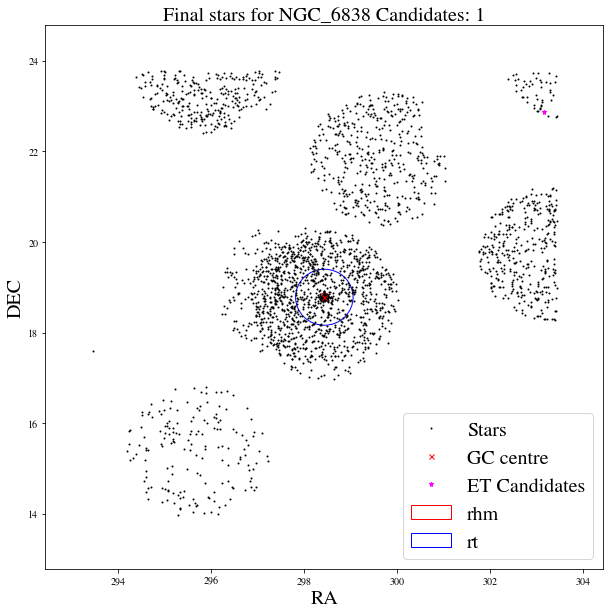


That shit took  1.6903698404630025  mins


"wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')\nplay_obj = wave_obj.play()\nplay_obj.wait_done()\nplay_obj.stop()"

In [92]:
start = time.time()

for i in tqdm(range(31,32)):
    try:
        os.makedirs('GCs_20RHMRT_2/' + GC_name_arr[i])
    except OSError as error:
        print('Directory ' + GC_name_arr[i] + ' already exists')

    tsne_eps_all, tsne_samp_all = db(GC_name_arr[i], 'tsne', tsne_all_X_norad[i], tsne_all_Y_norad[i], tsne_ctrl_lab[i])
    umap_eps_all, umap_samp_all = db(GC_name_arr[i], 'umap', umap_all_X_norad[i], umap_all_Y_norad[i], umap_ctrl_lab[i])


    tsne_et = db_opt(GC_name_arr[i], 'tsne', tsne_all_X_norad[i], tsne_all_Y_norad[i], tsne_eps_all, tsne_samp_all, tsne_ctrl_lab[i])
    umap_et = db_opt(GC_name_arr[i], 'umap', umap_all_X_norad[i], umap_all_Y_norad[i], umap_eps_all, umap_samp_all, umap_ctrl_lab[i])

    temp_var = final_et_stars(tsne_ctrl_lab[i], umap_ctrl_lab[i], tsne_et, umap_et)[0]

    #final_tsne.append(final_et_stars(control_indices_norad[i], tsne_et, umap_et)[1])
    #final_umap.append(final_et_stars(control_indices_norad[i], tsne_et, umap_et)[2])

    if len(temp_var) == 0:
        print('Nothing to plot, you got no controls yo')
    else:
        final_et_arr[i] = (plot_shit_and_rt_filter(GC_name_arr[i], i, temp_var))

    
end = time.time()
print('That shit took ', (end - start) / 60, ' mins')

'''wave_obj = sa.WaveObject.from_wave_file('Doja_Cat_Mooo.wav')
play_obj = wave_obj.play()
play_obj.wait_done()
play_obj.stop()'''

In [153]:
play_obj.stop()

In [138]:
apogee_nofilt

,# APOGEE_ID_,GAIAEDR3_SOURCE_ID,RA,DEC,VHELIO_AVG,VERR,VSCATTER,TEFF,TEFF_ERR,LOGG,...,S_FE_ERR,K_FE_ERR,CA_FE_ERR,TI_FE_ERR,TIII_FE_ERR,V_FE_ERR,CR_FE_ERR,MN_FE_ERR,CO_FE_ERR,NI_FE_ERR
0,2M00000068+5710233,538028216707715712,0.002850,57.173164,-12.673787,0.029277,0.120245,5035.6900,48.670216,3.416017,...,0.033759,0.069656,0.042801,0.050515,0.090195,0.089703,0.049440,0.058999,0.343203,0.041848
1,2M00000133+5721163,2413929812587459072,0.005558,57.354549,-101.713486,0.066520,0.124213,4972.7134,46.113050,2.402370,...,0.058685,0.086153,0.063082,0.090245,0.064706,0.112211,0.065294,0.068275,0.108428,0.053906
2,2M00000211+6327470,422596679964513792,0.008802,63.463078,-106.631860,0.029086,0.053485,4696.9010,26.962519,2.224851,...,0.050642,0.042538,0.034654,0.037532,0.036766,0.069267,0.027521,0.035404,0.056741,0.034202
3,2M00000233+1452324,422596679964513792,0.009748,14.875667,-38.495186,0.026902,0.053984,4741.8716,80.308900,4.270293,...,0.060693,0.151140,0.072959,0.078504,0.157125,0.098980,0.080651,0.096100,0.065771,0.080449
4,2M00000446+5854329,4689447878791422208,0.018603,58.909149,-48.046894,0.031516,0.031308,4768.0040,25.617336,2.429237,...,0.028433,0.048315,0.029921,0.036650,0.034160,0.078822,0.027886,0.033394,0.040834,0.027055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370055,2M23590214+1435166,1499086767630458368,359.758939,14.587962,-89.050560,0.029243,0.110584,4686.8420,24.910856,2.617401,...,0.031427,0.051146,0.030787,0.042855,0.037961,0.083147,0.038112,0.035892,0.030015,0.029447
370056,2M23593035+1444283,3664628760244345600,359.876459,14.741221,24.179094,0.022893,0.027940,4983.8203,39.287434,2.635594,...,0.043323,0.055856,0.041475,0.038697,0.037045,0.126882,0.048540,0.048035,0.085143,0.037728
370057,2M23593169+5728016,1257993760630656768,359.882046,57.467121,-25.373499,0.027473,0.082224,4716.3580,989.874400,0.209517,...,1.678371,1.008230,0.791015,309663.880000,0.621882,0.623979,0.681815,0.712939,1.286080,0.912791
370058,2M23594776+1524307,1495448135764429440,359.949033,15.408548,-21.232704,0.027778,0.093972,4709.2734,49.365166,2.041033,...,0.071290,0.196804,0.067982,0.067939,0.092466,0.134635,0.097245,0.065816,0.069048,0.064046


In [300]:
def plot_shit_2(name, n, final_et, controls):
    #plt.close('all')
    M3_ra = GC_db['RA'][n]
    M3_dec = GC_db['DEC'][n]
    M3_rhm = GC_db['rhm'][n]
    M3_rt = GC_db['rt'][n]
    M3_d_Sun = GC_db['R_Sun'][n] * 1e3
    M3_rhm_deg = math.degrees(math.atan(M3_rhm / M3_d_Sun))
    M3_rt_deg = math.degrees(math.atan(M3_rt / M3_d_Sun))
    M3_fov = 5

    
    M3_dict, M3_cols = master_load(M3_ra, M3_dec, M3_fov, apogee_nofilt, param_list, name, M3_rhm, M3_rt_deg)
    M3_stars_filt = master_filter(M3_dict, M3_cols)
    
    print(len(M3_stars_filt), 'stars in a 10x10 fov of the GC after filters')
    
    #print(apogee_nofilt.loc[apogee_nofilt['# APOGEE_ID_'] == M3_stars_filt[0][0]]['RA'].values[0])

    M3_ra_arr = np.empty(len(M3_stars_filt[0]), dtype=float)
    M3_dec_arr = np.empty(len(M3_stars_filt[0]), dtype=float)
    for count, i in enumerate(M3_stars_filt[0]):
        #print(i)
        M3_ra_arr[count] = apogee_nofilt.loc[apogee_nofilt['# APOGEE_ID_'] == i]['RA'].values[0]
        M3_dec_arr[count] = apogee_nofilt.loc[apogee_nofilt['# APOGEE_ID_'] == i]['DEC'].values[0]
        
    M3_rhm_circ = plt.Circle((M3_ra, M3_dec), M3_rhm_deg, color='r', fill=False, label='rhm')
    #M3_rhm_rt_circ = plt.Circle((M3_ra, M3_dec), (rhm_deg + rt_deg)/2, color='g', fill=False, label='1/2 rhm, rt')
    M3_rt_circ = plt.Circle((M3_ra, M3_dec), M3_rt_deg, color='b', fill=False, label='rt')
    
    #plt.figure(figsize=(10,10))
    fig, ax = plt.subplots(1, figsize=(10,10))
    ax.plot(M3_ra_arr, M3_dec_arr, 'ok', linestyle='none', markersize=1, label='Stars')
    ax.plot(M3_ra, M3_dec, color='red', marker='x', linestyle='none', markersize=5, label='GC centre')
    ax.plot(M3_ra_arr[controls], M3_dec_arr[controls], color='cyan', linestyle='none', marker='o', ms=5, label='Original controls')
    ax.plot(M3_ra_arr[final_et], M3_dec_arr[final_et], color='fuchsia', linestyle='none', marker='*', ms=5, label='Algorithm Identified controls')
    ax.add_patch(M3_rhm_circ)
    #ax.add_patch(rhm_rt_circ)
    ax.add_patch(M3_rt_circ)
    ax.set_xlabel('RA', fontsize=20)
    ax.set_ylabel('DEC', fontsize=20)
    ax.set_title('Final stars for ' + GC_name_arr[n], fontsize=20)
    ax.set_xlim(M3_ra - M3_fov - 1, M3_ra + M3_fov + 1)
    ax.set_ylim(M3_dec - M3_fov - 1, M3_dec + M3_fov + 1)
    ax.legend(loc='best', fontsize=20)
    plt.savefig('GCs_final3/' + name + '/incorrect_controls.png')
    #plt.show()
    ax.clear()
    fig.clear()
    plt.close(fig)


In [299]:
for i in range(31):
    plot_shit_2(GC_name_arr[i], i, control_indices_norad[i], control_indices_rad[i][0][0])

467 stars in a 10x10 fov of the GC
Directory NGC_104 already exists

The final amount of stars in our sample is: 467
51 stars in a 10x10 fov of the GC after filters
293 stars in a 10x10 fov of the GC
Directory NGC_288 already exists

The final amount of stars in our sample is: 287
51 stars in a 10x10 fov of the GC after filters
1218 stars in a 10x10 fov of the GC
Directory NGC_362 already exists

The final amount of stars in our sample is: 1215
51 stars in a 10x10 fov of the GC after filters
311 stars in a 10x10 fov of the GC
Directory NGC_1851 already exists

The final amount of stars in our sample is: 307
51 stars in a 10x10 fov of the GC after filters
248 stars in a 10x10 fov of the GC
Directory NGC_1904 already exists

The final amount of stars in our sample is: 246
51 stars in a 10x10 fov of the GC after filters
566 stars in a 10x10 fov of the GC
Directory NGC_2808 already exists

The final amount of stars in our sample is: 565
51 stars in a 10x10 fov of the GC after filters
1065 

# in combination: 3 overall checks
# 1. check between rt and rhm, whichever has overlaps (time consuming)
# 2. compare between two metrics for max: # of total group members vs. N / sigma^2 (pick the overlaps?)
# 3. check for lowest mean neighbour distance for ones that have the same metric (hasn't been coded yet but shouldnt be more than a few lines)